In [1]:
import tarfile
import matplotlib.pyplot as plt
from pathlib import Path
from dysh.util.download import from_url
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.util.selection import Selection
from dysh.spectra.core import average
import numpy as np
import pandas as pd

In [120]:
class HI_reduction:
    # class for reducing the HI spectra of blue blobs.
    def __init__(self, session_no):
        path_to_raw_vegas = f"/home/sdfits/AGBT24B_251_{session_no}/AGBT24B_251_{session_no}.raw.vegas/" 
        sdfits = GBTFITSLoad(path_to_raw_vegas, backend="VEGAS")
        self.spectra = sdfits
        self.sd_table = pd.DataFrame(sdfits.summary())
        self.unique_objects = self.sd_table["OBJECT"].unique()
        print("BCs to choose form:", self.unique_objects)
        self.specs = sdfits.rawspectra(0,0)
        pairs = int(len(self.sd_table["OBJECT"])/2)
        self.specs = np.reshape(self.specs, (pairs, 488, -1)) 
        #self.index = np.where(sd_table["OBJECT"] == unique_objects[0])
        pass

    def scan_list(self, BC_name):
        self.index = np.where(self.sd_table["OBJECT"] == BC_name)
        lscan = []
        for j in range(np.min(self.index) , np.max(self.index), 2):
            lscan.append(int(self.sd_table["SCAN"][j]))
        return lscan, self.index[0]

    def avg_spectra(self, scan_list):
        ps_scanblock = self.spectra.getps(scan = scan_list, plnum=0, apply_flags=True)
        ps = ps_scanblock.timeaverage()
        return ps
    
    def cutoff(self,scan_list):
        fig = plt.subplots(figsize = (12, 11))
        #Inspect the data
        for i in range(0,34,2):#scan_list[1][::2]:
            spec_new = self.specs[i]
            stdevs = np.std(spec_new,axis=1)
            #Organize into scan and switching state.
            #There are 2 scans for the target and reference pointings, 2 calibration diode states, and 2 polarizations.
            stdevs = np.reshape(stdevs, (2,-1,4))
            nrows = stdevs.shape[1]
            #Inspect the data
            for scan in range(2):
                for sw_state in range(4):
                    plt.plot(stdevs[scan,:-1,sw_state],label=f'scan {(4*scan)+sw_state}')
            plt.xlabel('Integration #')
            plt.ylabel('sigma')
            #plt.legend()
        return plt.show()
    
    def stat_flag(self, sigma, scan_list):
        flag_list = np.array([])
        for scans in scan_list:
            Single_spectra = self.spectra.getps(scan = scans, plnum=0)
            Single_spectra = Single_spectra.timeaverage()
            median_flux = np.array([np.median(Single_spectra.flux).value]*len(Single_spectra.flux))
            std_flux = np.array([np.std(Single_spectra.flux).value]*len(Single_spectra.flux))
            flag_mask = np.zeros(Single_spectra.shape)
            flag_mask[np.logical_or(Single_spectra.flux.value < median_flux - sigma*std_flux, Single_spectra.flux.value > median_flux + sigma*std_flux)] = 1
            flag_mask = flag_mask.flatten()
            flag_chan = np.where(flag_mask==1)[0].tolist()
            print(f"{scans} flags:", flag_chan)
            self.spectra.flag(scan = scans, channel=flag_chan, plnum=0)
            self.spectra.flag(scan = scans+1, channel=flag_chan, plnum=0)
            # if flag_chan not in flag_list, then append to flag_list
            for chan in flag_chan:
                if chan not in flag_list:
                    flag_list = np.append(flag_list, chan)

        return flag_list
    
    
            

In [121]:
Spectras = HI_reduction("02")

Flags were created from existing flag files. Use GBTFITSLoad.flags.show() to see them.
BCs to choose form: ['BC22' 'BC17' 'BC27']


In [122]:
BC22_scans = Spectras.scan_list("BC22")
BC22_scans

([6, 8, 10, 12, 14, 16],
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

In [123]:
BC22_sdfits = Spectras.spectra 

In [124]:
BC22_spectra = Spectras.avg_spectra(BC22_scans[0])

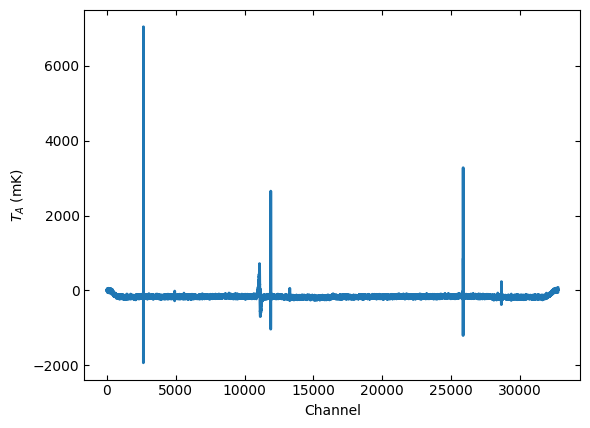

In [125]:
BC22_spectra.plot(xaxis_unit = "chan", yaxis_unit = "mK",y_min = -1000, y_max = 200)


In [107]:
flag_list = Spectras.stat_flag(3, BC22_scans[0])

6 flags: [2647, 2648, 11017, 11028, 11029, 11033, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11114, 11115, 11117, 11118, 11119, 11120, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 11139, 11140, 11141, 11142, 11143, 11144, 11145, 11146, 11147, 11148, 11149, 11150, 11151, 11152, 11153, 11154, 11155, 11156, 11157, 11158, 11159, 11160, 11161, 11162, 11163, 11164, 11165, 11166, 11167, 11168, 11169, 11170, 11171, 11172, 11173, 11174, 11175, 11176, 11177, 11178, 11179, 11180, 11181, 11182, 11183, 11184, 11185, 11186, 11187, 11188

In [126]:
BC22_sdfits.flags.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


In [111]:
BC22_spectra = Spectras.avg_spectra(BC22_scans[0])

INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


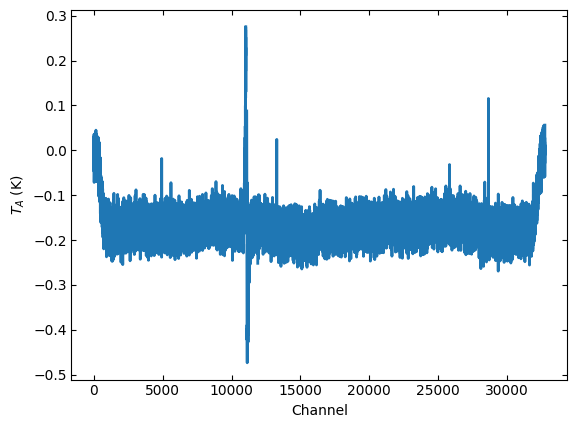

In [112]:
BC22_spectra.plot(xaxis_unit = "chan", yaxis_unit = "K",y_min = -1000, y_max = 200)


In [98]:
flag_list = [int(x) for x in flag_list]

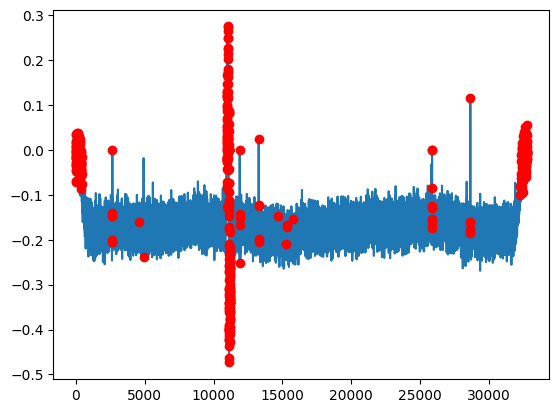

In [99]:
plt.plot(BC22_spectra.flux.value)
plt.plot(flag_list,BC22_spectra.flux.value[flag_list], 'ro')


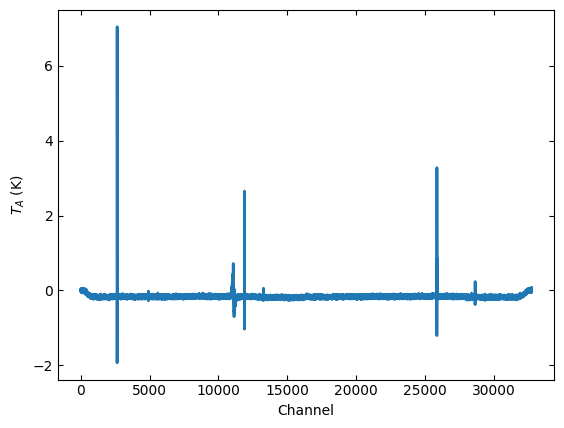

In [127]:
ps_scanblock = BC22_sdfits.getps(scan=BC22_scans[0], plnum=0)
ps = ps_scanblock.timeaverage()
ps.plot(xaxis_unit="chan")

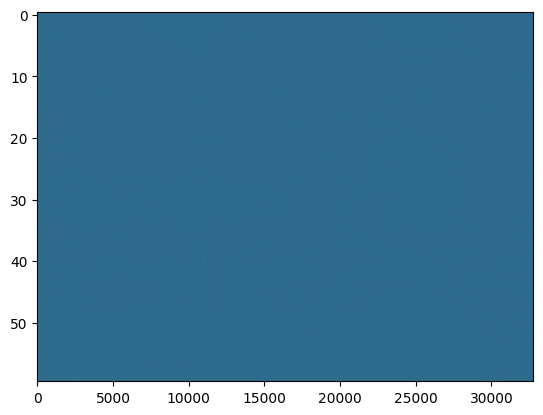

In [128]:
plt.figure()
plt.imshow(ps_scanblock[0]._calibrated, aspect="auto")

In [129]:
BC22_sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,97.59854,21.908178
1,7,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,99.79335,21.73278
2,8,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,99.39169,23.975813
3,9,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,100.781647,23.593848
4,10,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,101.231538,26.036336
5,11,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,102.421806,25.077636
6,12,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,103.146221,28.109582
7,13,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,104.875261,27.198765
8,14,BC22,801.0,OnOff,1,1.420406,1.420406,1,2,61,1,105.11463,30.160391
9,15,BC22,801.0,OnOff,2,1.420406,1.420406,1,2,61,1,106.438223,28.726869


In [84]:
flag_list

[2647,
 2648,
 11017,
 11028,
 11029,
 11033,
 11037,
 11038,
 11039,
 11040,
 11041,
 11042,
 11043,
 11044,
 11045,
 11046,
 11047,
 11048,
 11049,
 11050,
 11051,
 11052,
 11053,
 11054,
 11055,
 11056,
 11057,
 11058,
 11059,
 11060,
 11061,
 11062,
 11063,
 11064,
 11065,
 11066,
 11067,
 11068,
 11069,
 11070,
 11071,
 11072,
 11073,
 11074,
 11075,
 11076,
 11077,
 11078,
 11079,
 11080,
 11081,
 11082,
 11083,
 11084,
 11085,
 11086,
 11087,
 11088,
 11089,
 11090,
 11091,
 11092,
 11093,
 11094,
 11095,
 11096,
 11097,
 11098,
 11114,
 11115,
 11117,
 11118,
 11119,
 11120,
 11121,
 11122,
 11123,
 11124,
 11125,
 11126,
 11127,
 11128,
 11129,
 11130,
 11131,
 11132,
 11133,
 11134,
 11135,
 11136,
 11137,
 11138,
 11139,
 11140,
 11141,
 11142,
 11143,
 11144,
 11145,
 11146,
 11147,
 11148,
 11149,
 11150,
 11151,
 11152,
 11153,
 11154,
 11155,
 11156,
 11157,
 11158,
 11159,
 11160,
 11161,
 11162,
 11163,
 11164,
 11165,
 11166,
 11167,
 11168,
 11169,
 11170,
 11171,
 1

In [12]:
median_flux = np.array([np.median(BC22_spectra.flux).value]*len(BC22_spectra.flux))
std_flux = np.array([np.std(BC22_spectra.flux).value]*len(BC22_spectra.flux))

In [20]:
flag_mask = np.zeros(BC22_spectra.shape)
flag_mask[np.logical_or(BC22_spectra.flux.value < median_flux - 3*std_flux, BC22_spectra.flux.value > median_flux + 3*std_flux)] = 1
flag_mask = flag_mask.flatten()

flag_chan = np.where(flag_mask==1)[0].tolist()
print(flag_chan)


[53, 106, 120, 173, 232, 2644, 2645, 2646, 2647, 2648, 10981, 10982, 10983, 10987, 10988, 10990, 10993, 10996, 10997, 10999, 11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008, 11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026, 11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035, 11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044, 11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053, 11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062, 11063, 11064, 11065, 11066, 11067, 11068, 11069, 11070, 11071, 11072, 11073, 11074, 11075, 11076, 11077, 11078, 11079, 11080, 11081, 11082, 11083, 11084, 11085, 11086, 11087, 11088, 11089, 11090, 11091, 11092, 11093, 11094, 11095, 11096, 11097, 11098, 11099, 11100, 11101, 11102, 11103, 11104, 11106, 11119, 11121, 11122, 11123, 11124, 11125, 11126, 11127, 11128, 11129, 11130, 11131, 11132, 11133, 11134, 11135, 11136, 11137, 11138, 

In [52]:
scan_list = [i for i in range(BC22_scans[0][0], BC22_scans[0][-1] + 1)]
scan_list

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [53]:
BC22_sdfits.flag(scan = scan_list, channel=[flag_chan])

In [45]:
BC22_sdfits.flags.clear()
BC22_sdfits.flags.show()


 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


(-0.4, 0.1)

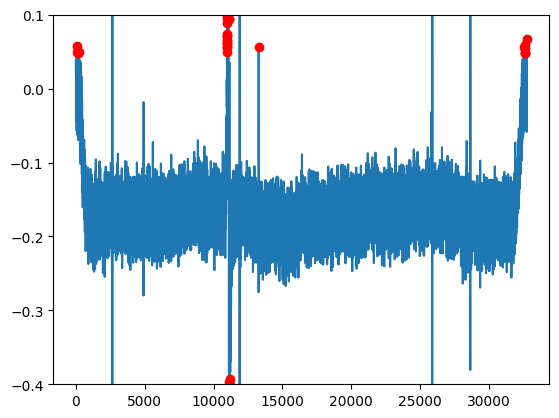

In [58]:
plt.plot(BC22_spectra.flux.value)
plt.plot(flag_chan,BC22_spectra.flux.value[flag_chan], 'ro')
plt.ylim(-0.4,0.1)

In [56]:
pssb = BC22_sdfits.getps(scan= scan_list, plnum=0, apply_flags=True)


INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]
INFO: overwriting Masked Quantity's current mask with specified mask. [astropy.nddata.nddata]


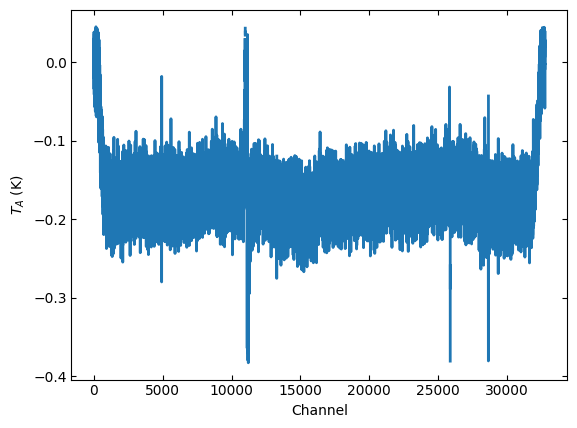

In [62]:
ps = pssb.timeaverage()
ps.plot(xaxis_unit="chan")